In [18]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [19]:
import pickle
import numpy as np

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from torchsampler import ImbalancedDatasetSampler
from torch.optim import lr_scheduler

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [20]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [21]:
# используем враппер над датасетом для удобной работы

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train':
            transform = transforms.Compose([
                 transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                 transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                 ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        
        
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [22]:
# Для вывода картинок с Симпсонами
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [23]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [24]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [25]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [26]:
val_dataset

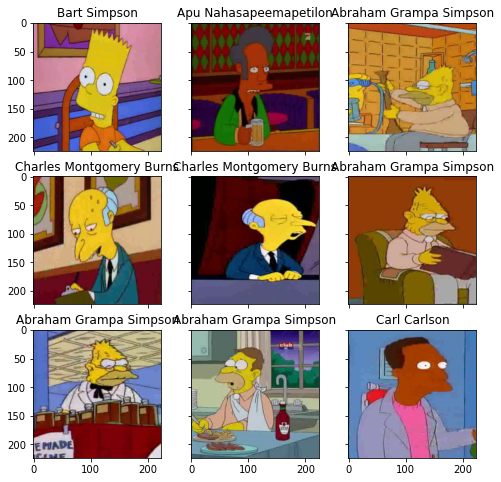

In [27]:
# Посмотрим на наших героев внутри датасета.

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Построение нейросети
#### Пробовал многие сети, но остановился на ПРЕДОБУЧЕННОЙ inception V3 (с разморозкой двух последних слоев), как давшей наибольший score на Kaggle



In [48]:

def fit_epoch(model, train_loader, criterion, optimizer):
    model.train(True)
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs, aux_outputs = model(inputs)
        loss1 = criterion(outputs, labels)     # Адаптация под inception V3
        loss2 = criterion(aux_outputs, labels) # Адаптация под inception V3
        loss = loss1 + 0.4*loss2               # Адаптация под inception V3
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [29]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [39]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())     # Использую оптимизатор AdamW  из-за регуляризации (чтоб сеть не расходилась)
        criterion = nn.CrossEntropyLoss()
        scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)  # добавил чедулер
        for epoch in range(epochs):
            
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [40]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [41]:
n_classes = len(np.unique(train_val_labels))

In [42]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

##  inception V3

In [43]:
# Загружаю обученную модель
model_inception_v3 = models.inception_v3(pretrained=True)

In [44]:
# размораживаем ТОЛЬКО два последних слоя
for param in model_inception_v3.parameters():
    param.requires_grad = False

for param in model_inception_v3.Mixed_7b.parameters():
    param.requires_grad = True
    
for param in model_inception_v3.Mixed_7c.parameters():
    param.requires_grad = True    

In [45]:
# Handle the auxilary net
num_ftrs = model_inception_v3.AuxLogits.fc.in_features
model_inception_v3.AuxLogits.fc = nn.Linear(num_ftrs, n_classes)
# Handle the primary net
num_ftrs = model_inception_v3.fc.in_features
model_inception_v3.fc = nn.Linear(num_ftrs,  n_classes)

print(model_inception_v3)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [46]:
model_inception_v3 = model_inception_v3.to(DEVICE)

In [47]:
# все изображения будут масштабированы к размеру 299x299 (особенность, так обучался inception)
RESCALE_SIZE = 299

In [70]:
#Обучение
history = train(train_dataset, val_dataset, model=model_inception_v3, epochs=30, batch_size=64)

epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 0.9282006675331097


epoch:   3%|██▍                                                                      | 1/30 [05:20<2:34:40, 320.00s/it]


Epoch 001 train_loss: 0.9282     val_loss 0.6449 train_acc 0.8376 val_acc 0.8506
loss 0.3784333954905923


epoch:   7%|████▊                                                                    | 2/30 [10:38<2:28:59, 319.25s/it]


Epoch 002 train_loss: 0.3784     val_loss 0.3240 train_acc 0.9283 val_acc 0.9159
loss 0.2672556668445938


epoch:  10%|███████▎                                                                 | 3/30 [15:57<2:23:37, 319.15s/it]


Epoch 003 train_loss: 0.2673     val_loss 0.4018 train_acc 0.9491 val_acc 0.9014
loss 0.19717323576935508


epoch:  13%|█████████▋                                                               | 4/30 [21:16<2:18:16, 319.09s/it]


Epoch 004 train_loss: 0.1972     val_loss 0.2443 train_acc 0.9613 val_acc 0.9415
loss 0.1383668372046986


epoch:  17%|████████████▏                                                            | 5/30 [26:35<2:12:56, 319.06s/it]


Epoch 005 train_loss: 0.1384     val_loss 0.2633 train_acc 0.9726 val_acc 0.9345
loss 0.14321722711481952


epoch:  20%|██████████████▌                                                          | 6/30 [31:55<2:07:39, 319.16s/it]


Epoch 006 train_loss: 0.1432     val_loss 0.2518 train_acc 0.9712 val_acc 0.9406
loss 0.1195743799043963


epoch:  23%|█████████████████                                                        | 7/30 [37:14<2:02:21, 319.20s/it]


Epoch 007 train_loss: 0.1196     val_loss 0.2434 train_acc 0.9764 val_acc 0.9436
loss 0.046644298546146726


epoch:  27%|███████████████████▍                                                     | 8/30 [42:35<1:57:12, 319.67s/it]


Epoch 008 train_loss: 0.0466     val_loss 0.1112 train_acc 0.9906 val_acc 0.9794
loss 0.01762679330359178


epoch:  30%|█████████████████████▉                                                   | 9/30 [47:56<1:52:05, 320.29s/it]


Epoch 009 train_loss: 0.0176     val_loss 0.1064 train_acc 0.9973 val_acc 0.9790
loss 0.014449307964242061


epoch:  33%|████████████████████████                                                | 10/30 [53:15<1:46:35, 319.79s/it]


Epoch 010 train_loss: 0.0144     val_loss 0.1063 train_acc 0.9975 val_acc 0.9809
loss 0.0076212532421679234


epoch:  37%|██████████████████████████▍                                             | 11/30 [58:35<1:41:15, 319.77s/it]


Epoch 011 train_loss: 0.0076     val_loss 0.1040 train_acc 0.9987 val_acc 0.9809
loss 0.005653446951112335


epoch:  40%|████████████████████████████                                          | 12/30 [1:03:55<1:35:56, 319.81s/it]


Epoch 012 train_loss: 0.0057     val_loss 0.1050 train_acc 0.9996 val_acc 0.9807
loss 0.0050963466747405445


epoch:  43%|██████████████████████████████▎                                       | 13/30 [1:09:16<1:30:45, 320.32s/it]


Epoch 013 train_loss: 0.0051     val_loss 0.1067 train_acc 0.9991 val_acc 0.9811
loss 0.003153991424716182


epoch:  47%|████████████████████████████████▋                                     | 14/30 [1:14:37<1:25:27, 320.46s/it]


Epoch 014 train_loss: 0.0032     val_loss 0.1070 train_acc 0.9996 val_acc 0.9801
loss 0.0026566071827315812


epoch:  50%|███████████████████████████████████                                   | 15/30 [1:19:57<1:20:06, 320.43s/it]


Epoch 015 train_loss: 0.0027     val_loss 0.1068 train_acc 0.9997 val_acc 0.9805
loss 0.002693576480921839


epoch:  53%|█████████████████████████████████████▎                                | 16/30 [1:25:18<1:14:49, 320.65s/it]


Epoch 016 train_loss: 0.0027     val_loss 0.1077 train_acc 0.9997 val_acc 0.9801
loss 0.002240855276384823


epoch:  57%|███████████████████████████████████████▋                              | 17/30 [1:30:39<1:09:27, 320.56s/it]


Epoch 017 train_loss: 0.0022     val_loss 0.1061 train_acc 0.9999 val_acc 0.9817
loss 0.0022454485889550086


epoch:  60%|██████████████████████████████████████████                            | 18/30 [1:36:00<1:04:08, 320.73s/it]


Epoch 018 train_loss: 0.0022     val_loss 0.1063 train_acc 0.9998 val_acc 0.9801
loss 0.0017020454017234372


epoch:  63%|█████████████████████████████████████████████▌                          | 19/30 [1:41:20<58:46, 320.58s/it]


Epoch 019 train_loss: 0.0017     val_loss 0.1047 train_acc 0.9999 val_acc 0.9807
loss 0.0019182305829913914


epoch:  67%|████████████████████████████████████████████████                        | 20/30 [1:46:41<53:26, 320.62s/it]


Epoch 020 train_loss: 0.0019     val_loss 0.1079 train_acc 0.9999 val_acc 0.9799
loss 0.0019173483480321172


epoch:  70%|██████████████████████████████████████████████████▍                     | 21/30 [1:52:06<48:18, 322.09s/it]


Epoch 021 train_loss: 0.0019     val_loss 0.1071 train_acc 0.9997 val_acc 0.9813
loss 0.0020892365541776824


epoch:  73%|████████████████████████████████████████████████████▊                   | 22/30 [1:57:26<42:51, 321.45s/it]


Epoch 022 train_loss: 0.0021     val_loss 0.1082 train_acc 0.9999 val_acc 0.9809
loss 0.0020394997760943947


epoch:  77%|███████████████████████████████████████████████████████▏                | 23/30 [2:02:47<37:28, 321.21s/it]


Epoch 023 train_loss: 0.0020     val_loss 0.1091 train_acc 0.9997 val_acc 0.9813
loss 0.0019900443508189558


epoch:  80%|█████████████████████████████████████████████████████████▌              | 24/30 [2:08:08<32:06, 321.04s/it]


Epoch 024 train_loss: 0.0020     val_loss 0.1070 train_acc 0.9999 val_acc 0.9809
loss 0.0016033029412378878


epoch:  83%|████████████████████████████████████████████████████████████            | 25/30 [2:13:27<26:43, 320.65s/it]


Epoch 025 train_loss: 0.0016     val_loss 0.1079 train_acc 1.0000 val_acc 0.9807
loss 0.0018567310656847187


epoch:  87%|██████████████████████████████████████████████████████████████▍         | 26/30 [2:18:47<21:20, 320.25s/it]


Epoch 026 train_loss: 0.0019     val_loss 0.1069 train_acc 0.9999 val_acc 0.9809
loss 0.001728759186083826


epoch:  90%|████████████████████████████████████████████████████████████████▊       | 27/30 [2:24:06<16:00, 320.14s/it]


Epoch 027 train_loss: 0.0017     val_loss 0.1069 train_acc 1.0000 val_acc 0.9801
loss 0.0020298169464878684


epoch:  93%|███████████████████████████████████████████████████████████████████▏    | 28/30 [2:29:27<10:40, 320.27s/it]


Epoch 028 train_loss: 0.0020     val_loss 0.1053 train_acc 0.9998 val_acc 0.9811
loss 0.0019895437543309908


epoch:  97%|█████████████████████████████████████████████████████████████████████▌  | 29/30 [2:34:51<05:21, 321.41s/it]


Epoch 029 train_loss: 0.0020     val_loss 0.1059 train_acc 0.9997 val_acc 0.9828
loss 0.00185501345312369


epoch: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [2:40:13<00:00, 320.45s/it]


Epoch 030 train_loss: 0.0019     val_loss 0.1063 train_acc 0.9999 val_acc 0.9815


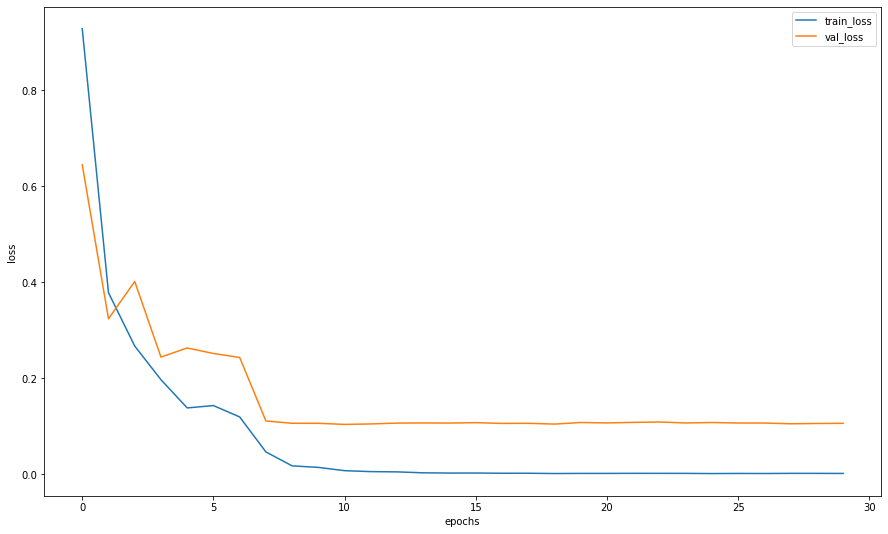

In [71]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

 ###   ИТОГ:

In [72]:
model_current=model_inception_v3

In [73]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [74]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_current, ex_img.unsqueeze(0))

In [75]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_current, imgs)

In [76]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [77]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [78]:
actual_labels

[0, 4, 0, 0, 1, 6, 0, 2, 4, 2, 0, 0, 5, 0, 4, 6, 2, 6, 6, 4]

In [79]:
preds_class

['abraham_grampa_simpson',
 'bart_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'agnes_skinner',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'apu_nahasapeemapetilon',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'carl_carlson',
 'abraham_grampa_simpson',
 'bart_simpson',
 'moe_szyslak',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'bart_simpson']

In [80]:
y_pred

array([ 0,  4,  0,  0,  1,  6,  0,  2,  4,  2,  0,  0,  5,  0,  4, 27,  2,
        6,  6,  4], dtype=int64)

In [81]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.9500000000000001

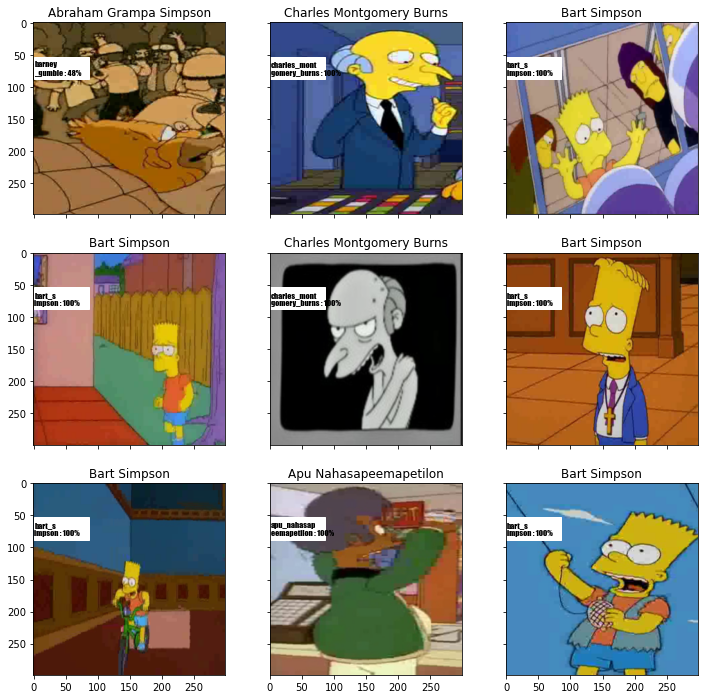

In [82]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_current, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [83]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_current, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [84]:
len(preds)

991

In [85]:
#создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('simpsons_simple_cnn_baseline.csv', index=False)

In [86]:
df.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
